In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.cm import get_cmap


In [4]:
# --- Damped harmonic oscillator model: ζ = damping ratio, ν0 = frequency (THz) ---
def damped_oscillator_zeta(t, zeta, nu0):
    A = 1  # Optional: make A a fitting parameter if amplitude varies a lot
    exp_term = np.exp(-2 * np.pi * zeta * nu0 * t)
    omega_d = 2 * np.pi * nu0 * np.sqrt(1 - zeta**2)
    cos_term = np.sqrt(1 - zeta**2) * np.cos(omega_d * t)
    sin_term = zeta * np.sin(omega_d * t)
    return A * exp_term * (cos_term - sin_term)

# --- Constants ---
t_ps = np.linspace(-2, 2, 1000)
t_pos = t_ps[t_ps > 0]
THz_to_cm = 33.35641  # 1 THz ≈ 33.35641 cm⁻¹

# --- Data paths ---
paths = {
    'freq1': '../data/equil_data/freq1_1d_vdos.dat',
    'freq11': '../data/equil_data/freq12_1d_vdos.dat',
    'freq23': '../data/equil_data/freq24_1d_vdos.dat',
}

# --- Load, compute VACFs, and fit for each dataset ---
results = {}

for label, path in paths.items():
    data = np.loadtxt(path)
    freqs_cm = data[0]
    omega = 2 * np.pi * 2.99792458e10 * freqs_cm * 1e-12  # rad/ps
    vdos_modes = data[1:]

    vacfs = []
    zetas = []
    freqs_fit = []

    for vdos in vdos_modes:
        vacf = np.array([
            np.trapz(vdos * np.cos(omega * t), x=omega)
            for t in t_ps
        ])
        vacf /= vacf[np.argmin(np.abs(t_ps))]
        vacfs.append(vacf)

        vacf_pos = vacf[t_ps > 0]
        try:
            popt, _ = curve_fit(
                damped_oscillator_zeta,
                t_pos,
                vacf_pos,
                p0=[0.05, 5],  # ζ, ν₀ in THz
                bounds=([0.001, 0.01], [0.9, 50])
            )
            zeta_fit, nu0_fit = popt
            zetas.append(zeta_fit)
            freqs_fit.append(nu0_fit * THz_to_cm)
        except RuntimeError:
            zetas.append(np.nan)
            freqs_fit.append(np.nan)

    results[label] = {
        'vacfs': vacfs,
        'zetas': zetas,
        'freqs_fit': freqs_fit,
        'vdos': vdos_modes,
        'freq_axis_cm': freqs_cm
    }

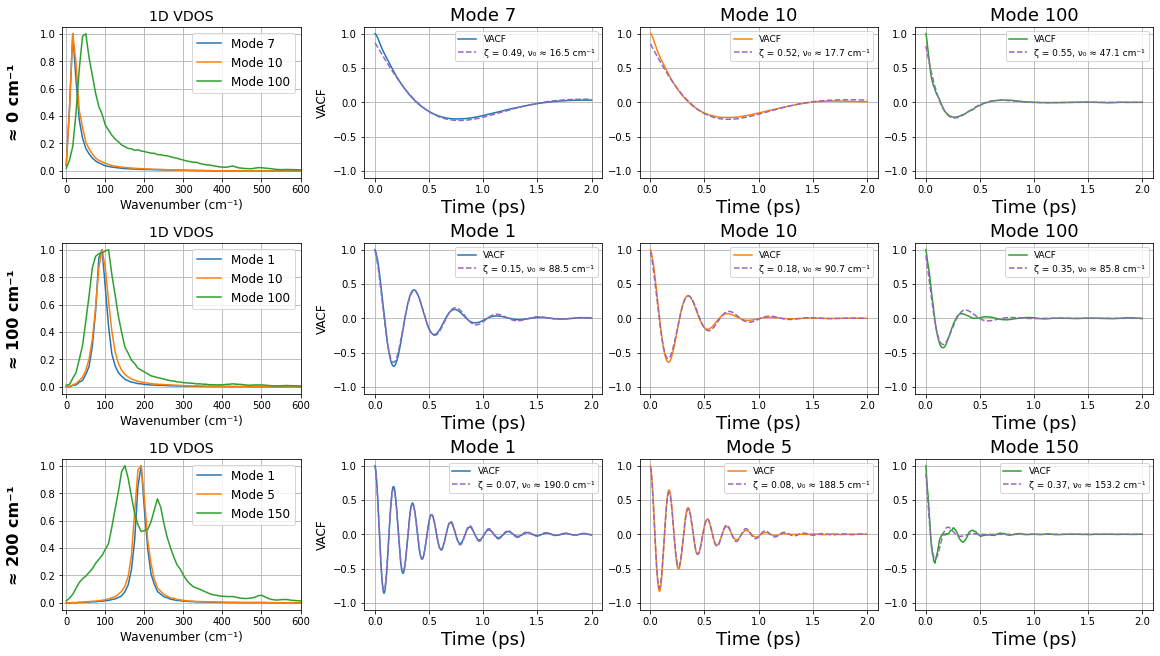

In [7]:
cmap = get_cmap('tab10')  # consistent colors across VDOS and VACF

row_titles = ["≈ 0 cm⁻¹", "≈ 100 cm⁻¹", "≈ 200 cm⁻¹"]

# Mode selections
modes_to_plot = {
    'freq1': [7, 10, 100],
    'freq11': [1, 10, 100],
    'freq23': [1, 5, 150],
}
row_labels = ['freq1', 'freq11', 'freq23']

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16, 9), constrained_layout=True)


for row_idx, (label, mode_indices) in enumerate(modes_to_plot.items()):
    vacfs = results[label]['vacfs']
    vdos = results[label]['vdos']  # shape: (num_modes, len(freq_axis))
    freq_axis_cm = results[label]['freq_axis_cm']
    
    
    # Plot VDOS traces (first column)
    ax_vdos = axs[row_idx, 0]
    for mode_idx, color_idx in zip(mode_indices, range(3)):
        vdos_curve = vdos[mode_idx]
        norm_vdos = vdos_curve / vdos_curve.max()
        ax_vdos.plot(freq_axis_cm, norm_vdos, label=f"Mode {mode_idx}", color=cmap(color_idx))
    
    ax_vdos.set_title("1D VDOS", fontsize=14)
    #ax_vdos.set_ylabel(label, fontsize=14)
    ax_vdos.set_xlabel("Wavenumber (cm⁻¹)", fontsize=12)
    ax_vdos.set_xlim(-10,600)
    #ax.tick_params(axis='both', labelsize=14)
    ax_vdos.legend(fontsize=12)
    ax_vdos.grid(True)

    # Plot VACF + Fit (columns 1–3)
    for col_idx, (mode_idx, color_idx) in enumerate(zip(mode_indices, range(3)), start=1):
        vacf = vacfs[mode_idx]
        vacf_pos = vacf[t_ps > 0]

        try:
            popt, _ = curve_fit(
                damped_oscillator_zeta,
                t_pos,
                vacf_pos,
                p0=[0.05, 5],
                bounds=([0.001, 0.01], [0.9, 50])
            )
            vacf_fit = damped_oscillator_zeta(t_pos, *popt)
            label_fit = f"ζ = {popt[0]:.2f}, ν₀ ≈ {popt[1] * THz_to_cm:.1f} cm⁻¹"
        except RuntimeError:
            vacf_fit = np.zeros_like(t_pos)
            label_fit = "Fit failed"

        ax = axs[row_idx, col_idx]
        ax.plot(t_pos, vacf_pos, label="VACF", color=cmap(color_idx), lw=1.5)
        ax.plot(t_pos, vacf_fit, '--', label=label_fit, color='tab:purple', lw=1.5)
        ax.set_title(f"Mode {mode_idx}", fontsize=18)
        ax.set_xlabel("Time (ps)", fontsize=18)
        #ax.tick_params(axis='both', labelsize=14)
        if col_idx == 1:
            ax.set_ylabel("VACF", fontsize=12)
        ax.set_ylim(-1.1, 1.1)
        ax.legend(fontsize=9)
        ax.grid(True)
        
# Add row labels (left side)
for row_idx, label in enumerate(row_titles):
    axs[row_idx, 0].annotate(
        label,
        xy=(-0.2, 0.5),
        xycoords='axes fraction',
        ha='center',
        va='center',
        fontsize=16,
        rotation=90,
        weight='bold'
    )


# Save high-resolution version
plt.savefig('/Users/bdneff/Desktop/VACF_VDOS_combined.png', dpi=600, bbox_inches='tight')
plt.show()

In [9]:
!conda env export > ../environment.yml
